# Tweets Sentiment Analysis -MIE1624-Assignment 1
#### Bibin K. Sebastian (1003752691)

## Data Preprocessing

## Import relevant Libraries


In [1]:
import pandas as pd
import numpy as np
import re # for regular expressions 
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
import html # for html unescape
import nltk
# nltk.download() # if the nltk data is not dowloaded aready 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


import warnings
warnings.filterwarnings('ignore') # to get rid of pesky warnings .Used only for final version to ensure the omission of relevant warnings


In [2]:
#Read the generic tweets  and Airline tweets as a dataframe
g_twt = pd.read_csv("generic_tweets.txt")
air_twt = pd.read_csv("US_airline_tweets.csv")

In [3]:
g_twt.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Check if there are any missing values 
g_twt.isnull().sum()

class    0
id       0
date     0
query    0
user     0
text     0
dtype: int64

In [5]:
# Function to explore the tweets
def explore(g_twt):
    # to check if the tweets were outcome of any particular query
    print("Value Counts  in the Class column:\r\n{}".format(g_twt["class"].value_counts()))# check the distribution of the two different classes 
    print("Unique Values in the query column: {}".format( g_twt["query"].unique())) # # check the values in query colum
    plt.style.use("tableau-colorblind10")
    g_twt["class"].hist() ## to check the distribution of the tweet classes
    plt.title("Histogram of Sentiments")
    plt.xlabel("Sentiment")
    plt.ylabel("Tweet Counts")

Value Counts  in the Class column:
4    100000
0    100000
Name: class, dtype: int64
Unique Values in the query column: ['NO_QUERY']


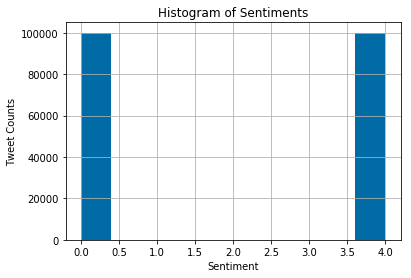

In [6]:
explore(g_twt) # explore the generic tweet DF 

** Positive and negative tweets are evenly distributed . No information to be generated from Query column, we can safely drop that column**

***isolating the two columns that we need work with, to another dataframe ***


In [7]:
df = g_twt[["class", "text"]]

In [8]:
# converting class 4 to 1 for better understamnding
df["class"] = df["class"].apply(lambda x: 0 if x == 0 else 1 ) ## 0 is for negative sentiment 1 for positive  

In [9]:
# sanity check 
print(df["class"].unique())
df["class"] = df["class"].astype('int')

[0 1]


In [10]:
# to compare the lengths after tweet cleaning
df["pre_clean_len"] = df["text"].apply(lambda x : len(x))

In [11]:
df.head()

,class,text,pre_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


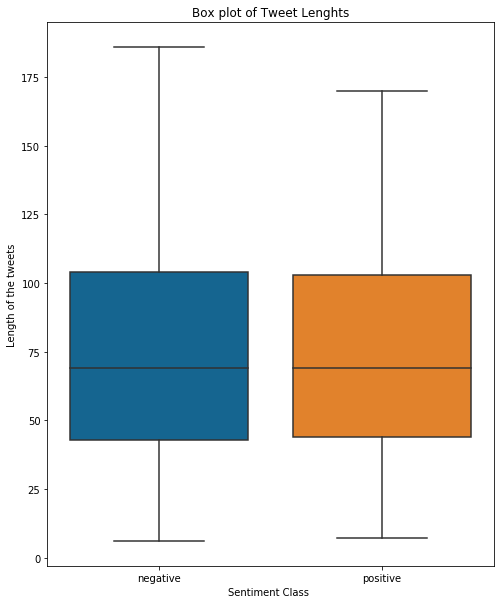

In [12]:
# box plot to see the length of the tweets 
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(y="pre_clean_len",x="class", data=df,orient="vertical")
plt.title("Box plot of Tweet Lenghts")    
plt.ylabel("Length of the tweets")
plt.xlabel("Sentiment Class ")
plt.xticks(ticks=[0,1],labels=['negative','positive'])          
plt.show()


In [13]:
df.groupby("class").mean() # Tweet length mean 

,pre_clean_len
class,
0,73.76126
1,74.15825


In [14]:
df.groupby("class").std() # Tweet length standard deviation 

,pre_clean_len
class,
0,36.731248
1,35.994691


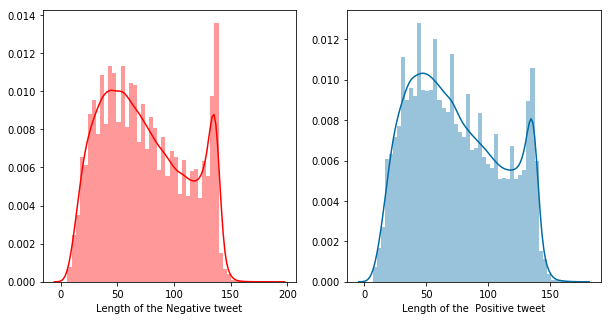

In [15]:
# Tweet length histogram comparison
fig, (ax1,ax2) =plt.subplots(ncols=2,nrows=1,figsize = (10,5))
sns.distplot(df[df["class"] ==0].pre_clean_len, ax=ax1,axlabel="Length of the Negative tweet",norm_hist=False,color="red")
sns.distplot(df[df["class"] ==1].pre_clean_len, ax=ax2,axlabel="Length of the  Positive tweet")

** Both Classes have  quite similar mean and standard deviation in terms of tweet lengths, which gives confidence that the data is not much skewed and not inherently biased **

In [16]:
stop_w_nltk = stopwords.words("english") # importing stop words form NLTK

**NLTK stop words contain some negative words that I believe should not be removed for twitter sentiment analysis. So We need to remove them from the stop words list . While doing the data cleaning, I observed that certain contractions such as "don't" gets removed . We need to fix them by replacing the contractions with their extended versions (don't and  dont will be replaced by do not)  ** <br>
** As $Bonus$, I explored the dataset further, and found basic emojies such as :-), :-( etc that may provide some additional information . So I replaced them with words that convey similar meaning. It improved my accuracy a bit  **

In [17]:

Black_list_words = ['over','only','very','against','angry','no','not','kiss','smile','grin','wink','cool','heart','shock',\
                   'broken','cry','sad'] # words that needs to be removed from the stop words
stop_w_nltk = list(set(stop_w_nltk) - set(Black_list_words))
contractions = [
   (r'aren.?t', 'are not'),
    (r'can.?t', 'can not'),
    (r'couldn.?t', 'could not'),
    (r'daren.?t', 'dare not'),
    (r'didn.?t', 'did not'),
    (r'doesn.?t', 'does not'),
    (r'don.?t', 'do not'),
    (r'isn.?t', 'is not'),
    (r'hasn.?t', 'has not'),
    (r'haven.?t', 'have not'),
    (r'hadn.?t', 'had not'),
    (r'mayn.?t', 'may not'),
    (r'mightn.?t', 'might not'),
    (r'mustn.?t', 'must not'),
    (r'needn.?t', 'need not'),
    (r'oughtn.?t', 'ought not'),
    (r'shan.?t', 'shall not'),
    (r'shouldn.?t', 'should not'),
    (r'wasn.?t', 'was not'),
    (r'weren.?t', 'were not'),
    (r'won.?t', 'will not'),
    (r'wouldn.?t', 'would not'),
    (r'ain.?t', 'am not'),
    (r'would.?ve', 'would have'),
    
]

EMOJIS = [
    (r'<3', 'heart'),
    (r':-o', 'shock'),
    (r':D', 'grin'),
    (r':\(', 'angry'),
    (r'B-\)', 'cool'),
    (r':\'\(', 'cry'),
    (r';\)', 'wink'),
    (r':-D', 'grin'),
    (r':P', 'tonge'),
    (r'}:-\)', 'devil'),
    (r':?\)', 'smile'),
    (r'</3', 'broken heart'),
    (r':-x', 'kiss'),
    (r':\*', 'kiss'),
    (r':-\(', 'sad')
]

In [18]:
len(stop_w_nltk)

173

In [19]:
stemmer = SnowballStemmer("english") # create the stemmer instance

## **Defining a function that will map the contractions to their full form, clean tweets of html tags, attributes, @ mentions, URLs, change the case, remove stop words and run the word stemmer   **

In [20]:

def clean(text):
    '''
    Function to force lower case , remove html tags and attributes, html character codes and replace with ASCII equivalent,
    URLs
    '''  
    for t in EMOJIS: # map the emojis to words
        text = re.sub(t[0], t[1], text)
    for t in contractions: # map the contractions to full form 
        text = re.sub(t[0], t[1], text)
    text = html.unescape(text) # to replace html character codes with ASCII equivalent
    text = text.lower() # lower the whole text 
    text = re.sub('(<[^>]+>)|\d+',' ',  text) # remove html id and attributes and numbers
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)# remove @tags, special chars , links 
    text = [word for word in text.split() if word not in stop_w_nltk] # remove Stop words
    text = [stemmer.stem(word) for word in text] # running stemmer 
    
    return(text)
    
        

In [21]:
# let's test the cleaner

In [22]:
# this string contains html tags , special chars, URL etc 
test1 = "https://stackoverflow.com/ <body> This assignment is pretty good don't stop learning</body>  @Sanjeev %#$**@&#@ "

In [23]:
# this contains html character codes 
test2 = ":-) Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by . good writer&amp;reviewed correctly.232323 "

In [24]:
test=[]
test.append(test1)
test.append(test2)
test= pd.DataFrame(test)
test.rename(columns={0:'text'}, inplace=True)

In [25]:
print(test["text"].apply(clean)[0])
print(test["text"].apply(clean)[1])

['assign', 'pretti', 'good', 'not', 'stop', 'learn']
['smile', 'whing', 'client', 'boss', 'not', 'understand', 'english', 'well', 'rewrot', 'text', 'unread', 'written', 'good', 'writer', 'review', 'correct']


**Cleaner does what it is supposed to do <br>
All html tags and attributes (i.e., /<[^>]+>/) are removed.<br>
Html character codes (i.e., &...;) are replaced with an ASCII equivalent.<br>
All URLs are removed.<br>
All characters in the text are in lowercase.<br>
All stopwords are removed. Be clear in what you consider as a stopword.<br>
If a tweet is empty after pre-processing, it should be preserved as such.<br>
replaced some important emojies to words **

In [26]:
# run clean function on the text 
df["cleaned"] = df["text"].apply(clean)

In [27]:
df["post_clean_len"] = df["cleaned"].apply(lambda x : len(x))

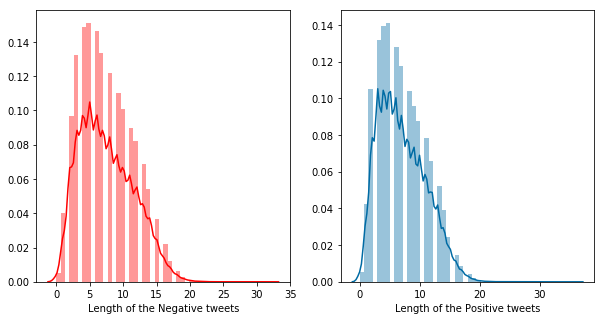

In [28]:
#distribution of the length of the tweets after cleaning. 
fig, (ax1,ax2) =plt.subplots(ncols=2,nrows=1,figsize = (10,5))
sns.distplot(df[df["class"] ==0].post_clean_len, ax=ax1,axlabel="Length of the Negative tweets",color="red")
sns.distplot(df[df["class"] ==1].post_clean_len, ax=ax2,axlabel="Length of the Positive tweets")


** We cleaned the tweets quite intensly and the length of the tweets came down drastically . However, distribution of the lengths remains more or less the same . That also means we cant really use text length as a feauture**

In [29]:
df.head()

,class,text,pre_clean_len,cleaned,post_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,"[zl, awww, bummer, shoulda, got, david, carr, ...",9
1,0,is upset that he can't update his Facebook by ...,111,"[upset, not, updat, facebook, text, might, cri...",12
2,0,@Kenichan I dived many times for the ball. Man...,89,"[dive, mani, time, ball, manag, save, rest, go...",9
3,0,my whole body feels itchy and like its on fire,47,"[whole, bodi, feel, itchi, like, fire]",6
4,0,"@nationwideclass no, it's not behaving at all....",111,"[no, not, behav, mad, not, see, over]",7


** to get a visual feedback .. creating wordcloud from the word frequecines and a word frequency graph $(Bonus)$**

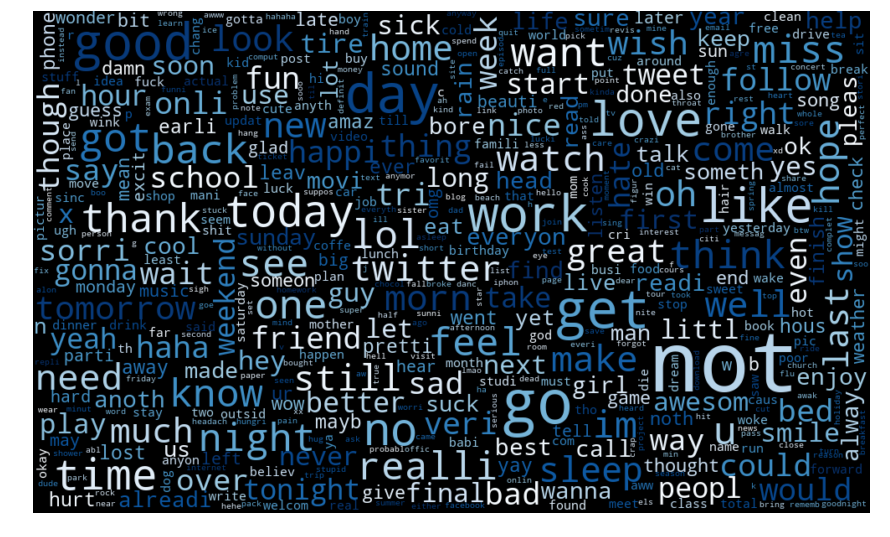

In [30]:

all_words = []
for line in df['cleaned']:
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcld = wordcloud.WordCloud(width=1000,height=600,max_words=500,max_font_size=100,relative_scaling=0.5,\
                              colormap='Blues',normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(15,10))
plt.imshow(wordcld, interpolation='bilinear')
plt.axis("off")
plt.show()

** words like 'not', 'love','good', 'night' stands out and it is quite understandable since this is a corpus of general tweets **

** We can view this in a frequency plot too $(Bonus)$ **

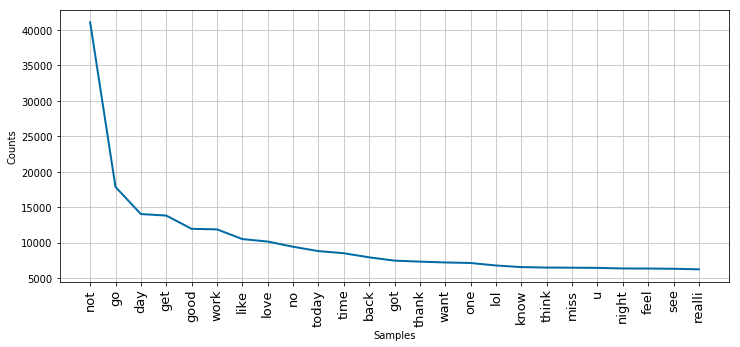

In [31]:
# We can view this in a Count plot too 
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(wordfreq)
fd.plot(25,cumulative=False)

## Fitting the model using Logistic regression on the generic tweets

** I worked with the bag of words model to create features needed for logistic regression. Started off with basic count vectorizer model, and fixated on 3 gram model with tfidf tranformation **

In [32]:
# Vectorising -Using bag of words model - I found the settings below works reasonably well after some good amount of trial

cv = CountVectorizer(analyzer='word',min_df = 4,ngram_range=(1,3),tokenizer=clean)

# analyzer='word' --- features will be made of words 
# min_df = 4 -- Ignore words or ngrams that do not repeat minimum of 4 times in the whole document(trims the vocab)
# ngram_range=(1,3) 1 to 3 words will be used to produce word combinations in the vocab 
# tokenizer=clean - apply the clean function rather than inbuilt tokenizer 


In [33]:
# fitting the count verctorizer instance to vocabulary in tweets
bag_of_words = cv.fit(df['text'])

In [34]:
#print(bag_of_words.vocabulary_) # printing out the vocabulary -- sanity check

In [35]:
len(bag_of_words.vocabulary_) # checking the length of the vocabulary as a sanity check 

63460

In [36]:
# Trasnforming the tweets to bag of words model 
bag_of_words = cv.transform(df['text'])
bag_of_words.shape # sanity check

(200000, 63460)

** After creating the bag of words, I tried to give weigh the entries with tfidf scores. This will give balance importance to high frequency words and less frequent words that may carry more information **

In [37]:
tfidf = TfidfTransformer()
bag_of_words = tfidf.fit_transform(bag_of_words)

In [38]:
bag_of_words.shape # gives a good idea if all the tweets have be transformed . 

(200000, 63460)

In [39]:
# Splitting the data to train and test and keeping the proportion same using stratify. 
X = bag_of_words
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 99,stratify = y) # stratify will keep the distribution of class same in both sets

In [40]:
y_train.value_counts()  # Checking the distribution of train set

1    70000
0    70000
Name: class, dtype: int64

In [41]:
classifier = LogisticRegression(random_state=99,n_jobs=-1) # fitting the classifier with most parameters being default
classifier.fit(X_train , y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=99, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
y_pred = classifier.predict(X_test) # Creating the prediction using test set

In [43]:
print (confusion_matrix(y_test , y_pred)) # create confusion matrix 

[[23365  6635]
 [ 5838 24162]]


** The basic Count vectorizer  with TFIDF transform fit was not too bad **

In [44]:
print (round(accuracy_score(y_test , y_pred) , 3)*100, "%") # accuracy on the test Set (79.2%)

79.2 %


In [45]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     30000
           1       0.78      0.81      0.79     30000

   micro avg       0.79      0.79      0.79     60000
   macro avg       0.79      0.79      0.79     60000
weighted avg       0.79      0.79      0.79     60000



In [46]:
## F1 score looks good and let us look at Area under the curve and THE ROC curve
roc_auc_score(y_test, y_pred)

0.7921166666666666

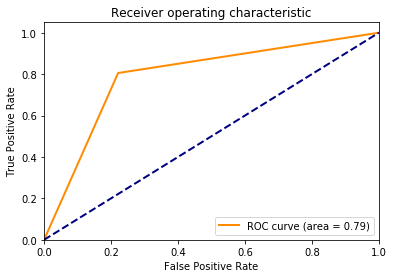

In [47]:

# Compute ROC curve and ROC area for each class (Bonus)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

** $(Bonus)$ Hyperparameter tuning on logistic regression and trying out different algorithms **

In [48]:
skd = StratifiedKFold(n_splits=5,random_state=99,shuffle=True) # using stratifiedKfold in the grid search -Create object for 5 fold CV
logit_params = {'penalty': ['l1','l2'],
               'C': [0.8,1.0,1.2,1.5,2,4]
               } # Grid search will be iterating over the combination of these parameters

logit_grid = GridSearchCV(classifier, logit_params,cv=skd, n_jobs=-1,verbose=True)
logit_grid.fit(X_train, y_train) # fit the gridsearch instance 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=99, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=99, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.8, 1.0, 1.2, 1.5, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [49]:
logit_grid.best_score_ # find the best accuracy inside the training set 

0.7873214285714286

In [50]:
best_classifier = logit_grid.best_estimator_ # saving the best regressor

In [51]:
y_pred_ht = best_classifier.predict(X_test) # predicting using the best regressor

In [52]:
accuracy_score(y_test,y_pred_ht)*100

79.17166666666667

** So only change from default logistic regression is that regularization parameter C could be bumped to 1.5.We did not get much performance improvement from gridsearch and we can pretty much confirm that we are in optimum level ** 

In [53]:
logit_grid.best_params_  # best parameters found using grid search

{'C': 1.5, 'penalty': 'l2'}

In [54]:
print (confusion_matrix(y_test , y_pred_ht)) # CM from the  best Classifier

[[23367  6633]
 [ 5864 24136]]


In [55]:
print (confusion_matrix(y_test , y_pred))  # CM from the  earlier Classifer

[[23365  6635]
 [ 5838 24162]]


In [56]:
print(classification_report(y_test , y_pred_ht))  # Precision and recall are almost same from before 

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     30000
           1       0.78      0.80      0.79     30000

   micro avg       0.79      0.79      0.79     60000
   macro avg       0.79      0.79      0.79     60000
weighted avg       0.79      0.79      0.79     60000



** Trying out Multinomial NB and SVM to get a comparison $(Bonus)$**

In [57]:
from sklearn.naive_bayes import MultinomialNB


In [58]:
classifier_nb = MultinomialNB(alpha=0.9)

In [59]:
classifier_nb.fit(X_train , y_train)

MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)

In [60]:
y_pred_nb = classifier_nb.predict(X_test)

In [61]:
print (confusion_matrix(y_test , y_pred_nb))

[[23331  6669]
 [ 6925 23075]]


In [62]:
print(accuracy_score(y_test , y_pred_nb) * 100 ,"%")

77.34333333333333 %


** Trying SVM linear classifier ##

In [63]:
from sklearn import svm

In [64]:
classifier_svc = svm.LinearSVC()
classifier_svc.fit(X_train , y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [65]:
y_pred_svm = classifier_svc.predict(X_test)
print (confusion_matrix(y_test , y_pred_svm))

[[22876  7124]
 [ 6449 23551]]


In [66]:
accuracy_score(y_test , y_pred_svm)

0.7737833333333334

** We could see that tuned logistic regression does a better job in accuracy front ** 

# Applying the regressor on the US Air line data 


In [67]:
# separating only the sentiment and tweets from the main data frame 
df_air = air_twt[["sentiment", "text"]]

In [68]:
df_air.sentiment.value_counts(normalize=True) ## less positive tweets present in the corpus 

negative    0.795252
positive    0.204748
Name: sentiment, dtype: float64

In [69]:
# replacing the strings with 0 and 1 as done for the generic tweet corpus 
df_air["sentiment"] =df_air.sentiment.map({"negative": 0, "positive": 1}) 
df_air.head(3)

,sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...


In [70]:
# Transforming the us airline tweets to fit the countvectorizer created for generic tweets
bag_of_words_air = cv.transform(df_air["text"])

In [71]:
bag_of_words_air.shape ## looks like a good output 

(11541, 63460)

## predicting US Airline tweets sentiment using the earlier created logistic regression model

In [72]:
y_pred_a = best_classifier.predict(bag_of_words_air)
y_test_a = df_air["sentiment"].astype('int')

In [73]:
pd.value_counts(pd.Series(y_pred_a), normalize=True)  # so 71% of the overall tweets are predicted to be negative 

0    0.714756
1    0.285244
dtype: float64

In [74]:
print (confusion_matrix(y_test_a , y_pred_a))

[[7848 1330]
 [ 401 1962]]


In [75]:
print(classification_report(y_test_a , y_pred_a))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      9178
           1       0.60      0.83      0.69      2363

   micro avg       0.85      0.85      0.85     11541
   macro avg       0.77      0.84      0.80     11541
weighted avg       0.88      0.85      0.86     11541



In [76]:
print("Accuray of Logistic regression Model on US Airlines Data (Full set) is : " , \
round(accuracy_score(df_air["sentiment"] , y_pred_a) *100,2),"%")

Accuray of Logistic regression Model on US Airlines Data (Full set) is :  85.0 %


In [77]:
df_air["Predicted_sentiment"] = pd.Series(y_pred_a) # adding the predictions to dataframe

** This is not too bad given the dataset is very skewed towards negative class <br>**

In [78]:
# calculating the null accuracy 
print("Null Accuracy on  US Airlines Data (Full set) is : ", max(y_test_a.mean(), 1 - y_test_a.mean())* 100)

Null Accuracy on  US Airlines Data (Full set) is :  79.52517112901828


# Finding out mentioned US Airline names from tweets

In [79]:
air_twt["text"].head()

0    @VirginAmerica plus you've added commercials t...
1    @VirginAmerica it's really aggressive to blast...
2    @VirginAmerica and it's a really big bad thing...
3    @VirginAmerica seriously would pay $30 a fligh...
4    @VirginAmerica yes, nearly every time I fly VX...
Name: text, dtype: object

In [80]:
air_twt["text"].tail()

11536    @AmericanAir my flight was Cancelled Flightled...
11537        @AmericanAir right on cue with the delaysðŸ‘Œ
11538    @AmericanAir thank you we got on a different f...
11539    @AmericanAir leaving over 20 minutes Late Flig...
11540    @AmericanAir you have my money, you change my ...
Name: text, dtype: object

** looking at the tweets it is very possible that all the tweets starts with @airline mentions . <br>
We might be able to get away with only looking at the beginning of the tweets **

In [81]:
# while carrying out data exploration I found that there are airline names are repeated with different cases. So lets 
#lower all the letters 

In [82]:
# lowering cases of all the tweets and saving it to another variable
air_twt_lower = air_twt["text"].apply(lambda x: x.lower())

In [83]:
air_twt_lower.head()

0    @virginamerica plus you've added commercials t...
1    @virginamerica it's really aggressive to blast...
2    @virginamerica and it's a really big bad thing...
3    @virginamerica seriously would pay $30 a fligh...
4    @virginamerica yes, nearly every time i fly vx...
Name: text, dtype: object

In [84]:
# function that will find out airline name mentions in the beginning of tweets
def extract_airline_beg(text):
    result = []
    result.extend(re.findall("^@(\w{1,20})", text)) #regex to fetch the airline mentions 
    return(result)


In [85]:
# apply the function to extract airline names 
airlines = air_twt_lower.apply(extract_airline_beg)

airlines.head()

0    [virginamerica]
1    [virginamerica]
2    [virginamerica]
3    [virginamerica]
4    [virginamerica]
Name: text, dtype: object

** I would like to extract only unique airline names **

In [86]:
# Set will only keep unique entries
results = set()
for air in airlines:
    results.update(air)

In [87]:
len(results)

20

In [88]:
results

{'americanair',
 'andrewfallis',
 'deltaassist',
 'djevolutionhd',
 'eatgregeat',
 'jetblue',
 'lindaswc',
 'malhoit',
 'ninadavuluri',
 'nrhodes85',
 'sarahpompei',
 'sb5551',
 'scm1133',
 'southwestair',
 'timbennettg3',
 'united',
 'unitedâ',
 'usairways',
 'vanessaannz',
 'virginamerica'}

In [89]:
# Since we have a much smaller list, we could hand pick the airline names from this and discard the rest. 
#I have picked the airline names as below 

In [90]:
airline_names =['americanair',
 'jetblue',
 'southwestair',
 'united',
 'usairways',
 'virginamerica']
airline_names

['americanair',
 'jetblue',
 'southwestair',
 'united',
 'usairways',
 'virginamerica']

## segregating tweets aimed at different airlines (using regex to find only airline mentions in the beginning of the text) - Using the ground truth sentiment

In [91]:
twt_per_airline = dict()
neg_pos= dict()
for air in airline_names:
    t = '^@'+str(air)
    twt_per_airline[air] = df_air[air_twt_lower.str.contains(t)] # create a dict of dataframes seggregating differernt airlines
    neg_pos[air] = {"Negative" :twt_per_airline[air].sentiment.value_counts()[0],"Positive" :twt_per_airline[air].sentiment.value_counts()[1] }

In [92]:

y1= []
y2 = []
for air in airline_names:
    y1.append(neg_pos[air]['Negative'])
    y2.append(neg_pos[air]['Positive'])
    

In [93]:
neg_pos

{'americanair': {'Negative': 1920, 'Positive': 321},
 'jetblue': {'Negative': 898, 'Positive': 499},
 'southwestair': {'Negative': 1174, 'Positive': 557},
 'united': {'Negative': 2571, 'Positive': 475},
 'usairways': {'Negative': 2225, 'Positive': 264},
 'virginamerica': {'Negative': 179, 'Positive': 144}}

In [94]:
neg_pos_df = pd.DataFrame(neg_pos)

Text(0.5, 1.0, 'Airline tweet distribution among different airlines')

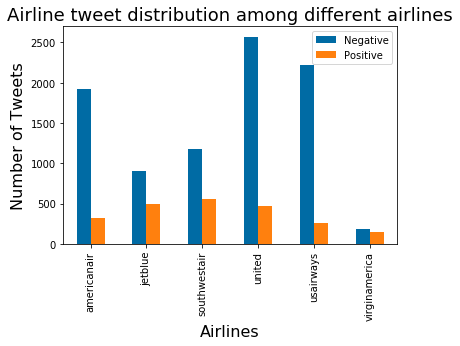

In [95]:
neg_pos_df.T.plot.bar()
plt.ylabel("Number of Tweets",fontsize=16)
plt.xlabel("Airlines",fontsize=16)
plt.title("Airline tweet distribution among different airlines",fontsize=18)

*** From the above graph, it is very clear that United, US Air, American  are having proportionately very high number of negative tweets . All the airlines have more negative tweets than the positive ones. It makes intuitive sense too since Twitter is a platform for the consumers to voice out their concerns and complaints . Virgin America has the least mentions on the tweets and percenagewise, they are in much better shape as far as negative tweets are concerned***

# Using the predictions done earlier on the US airline tweet corpus, Finding out the sentiment on individual airlines 

** The age of tweets makes sense since US Airways merged with American Air in 2015 <br>
I will now find out how many tweets belong to each airline by using $contains()$ method 
**

In [96]:
df_air["airline"]= pd.Series(np.zeros(air_twt_lower.shape)) # creating placeholder for airline names
air_tweets ={}
size=[]
for airlines in airline_names:
        t = '^@'+str(airlines)+"|" + '^.@'+str(airlines) # regex string to find the airlines that has @airline or .@airline tag in the beginning of the tweet
        air_tweets[airlines] = (air_twt_lower[air_twt_lower.str.contains(t,regex=True)].shape[0])
        ind = list(air_twt_lower[air_twt_lower.str.contains(t,regex=True)].index)
        df_air["airline"].loc[ind] = airlines
        size.append(air_twt_lower[air_twt_lower.str.contains(t,regex=True)].shape[0])

Text(0.5, 1.0, 'Tweet Counts per Airlines ')

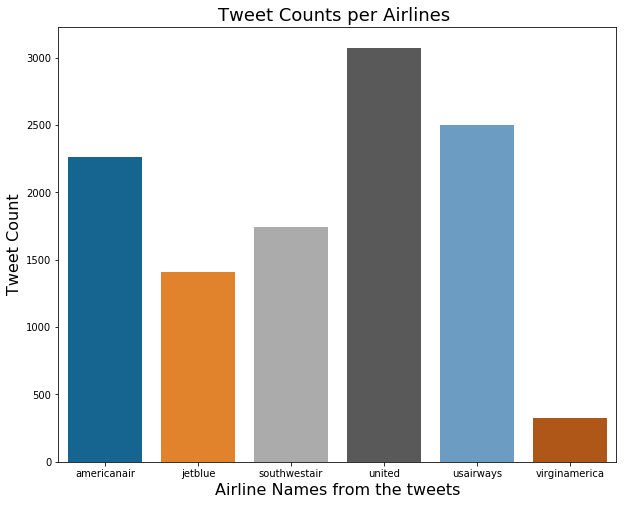

In [97]:
#  Let's Visualize 
fig = plt.figure(figsize=(10,8))
sns.barplot(airline_names,size,orient='v')
plt.xlabel("Airline Names from the tweets",fontsize=16)
plt.ylabel("Tweet Count",fontsize=16)
plt.title("Tweet Counts per Airlines ",fontsize=18)

*** Most of the tweets are aimed at United Airlines with US Air and American Air following closely***

In [98]:
air_tweets

{'americanair': 2260,
 'jetblue': 1410,
 'southwestair': 1740,
 'united': 3075,
 'usairways': 2503,
 'virginamerica': 327}

In [99]:
newdf = pd.crosstab(index=df_air['airline'], columns=df_air['Predicted_sentiment']) 
# Cross tab to find the percentage negative poitive tweets

In [100]:
# calculating the percentage Positive Tweets
newdf["Per_Pos"] = round(newdf[1]/(newdf[1]+ newdf[0]) *100,1)

In [101]:
# calculating the percentage Negative Tweets
newdf["Per_Neg"]= round(newdf[0]/(newdf[1]+ newdf[0]) *100,1)
newdf = newdf.drop(0)

In [102]:
newdf["Per_Pos"] # percentage of positive tweets about each air lines. It is pretty low 

airline
americanair      21.8
jetblue          39.2
southwestair     36.9
united           26.4
usairways        21.2
virginamerica    44.0
Name: Per_Pos, dtype: float64

In [103]:
newdf.Per_Neg# percentage of positive tweets about each air lines.

airline
americanair      78.2
jetblue          60.8
southwestair     63.1
united           73.6
usairways        78.8
virginamerica    56.0
Name: Per_Neg, dtype: float64

In [104]:
newdf = newdf.reset_index()

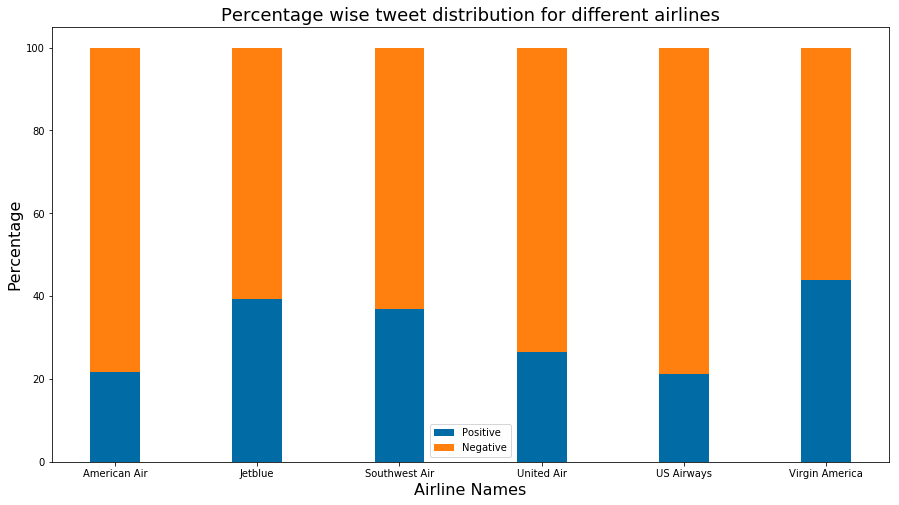

In [105]:
# plotting tjhe 
N = 6
ind = np.arange(N)
fig = plt.figure(figsize = (15,8))
p1 = plt.bar(ind, newdf["Per_Pos"], 0.35)
p2 = plt.bar(ind, newdf["Per_Neg"], 0.35,
             bottom=newdf["Per_Pos"])

plt.ylabel('Percentage',fontsize = 16)
plt.xlabel('Airline Names',fontsize = 16)
plt.title('Percentage wise tweet distribution for different airlines', fontsize = 18)
plt.xticks(ind, ('American Air', 'Jetblue', 'Southwest Air', 'United Air', 'US Airways','Virgin America'))
plt.legend((p1[0], p2[0]), ('Positive', 'Negative'))

plt.show()


### Another visualization of the counts

In [106]:
df_air["airline"].value_counts() 
# We couldnt pick 226 tweets which did not have the airline names at the front of the tweet

united           3075
usairways        2503
americanair      2260
southwestair     1740
jetblue          1410
virginamerica     327
0.0               226
Name: airline, dtype: int64

In [107]:
airline_sentiment = df_air[df_air["airline"]!=0.0].groupby(["airline","Predicted_sentiment"])["Predicted_sentiment"].count().to_frame()

In [108]:
airline_sentiment = airline_sentiment.rename(columns={"Predicted_sentiment":"Count"}).reset_index()


Text(0, 0.5, 'Count of Tweets')

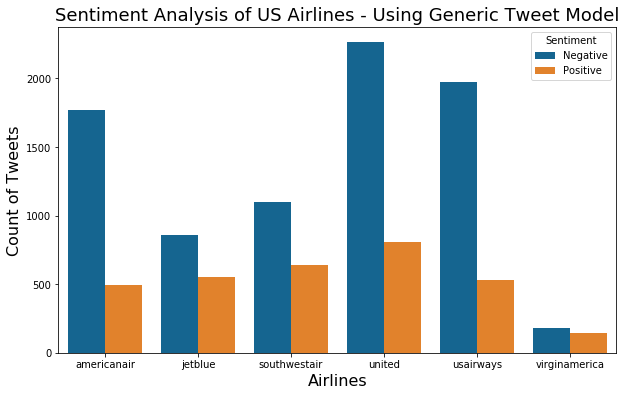

In [109]:
fig = plt.figure(figsize=(10,6))
ax = sns.barplot(data=airline_sentiment,x="airline",y="Count", hue="Predicted_sentiment")
legend = ax.legend_
legend.set_title("Sentiment")
for t, l in zip(legend.texts,("Negative", "Positive")):
    t.set_text(l)
plt.title("Sentiment Analysis of US Airlines - Using Generic Tweet Model",fontsize=18)
plt.xlabel("Airlines",fontsize=16)
plt.ylabel("Count of Tweets",fontsize=16)


### Discussion on the Research Question "***What can public opinion on Twitter tell us about the US airlines in 2015?***"

**
From our predictions using the logistic regression model , it is very clear that more than 71% of the tweets are negative in sentiment . <br>
Without looking at the ground truth labels , we can say that the overall sentiment of the tweets are negative. <br>However, We cannot come to a conclusion that this negative sentiment is representative of the whole US population since we do not know the representativeness of the data collected.<br>
In my opinion, the generic tweet model did a very good job in getting 85% accuracy  on a dataset with much different vocabulary of words <br>
United airlines has the maximum negative tweets followed by US airways and American air . However, percentagewise US Airways followed by American Air has the highest percentage of negative sentiment
**



In [110]:
# Sanity check -- to find the tweets without any airline mentions 
np.sum(list(air_tweets.values()))

11315

In [111]:
air_twt_lower.shape # number of total tweets. Looks like we have captured most of the airlines

(11541,)


## Multi class analysis on US airline sentiments


In [112]:
# creating a seprating dataframe for us to work with 
df_mult_full= air_twt[["sentiment", "negative_reason", "text"]]

In [113]:
df_mult_full.groupby("sentiment")["negative_reason"].count() # sanity check .. negative reasons are only attached for negative sentiment Tweets

sentiment
negative    9178
positive       0
Name: negative_reason, dtype: int64

In [114]:
# slicing only the negative sentiment tweets
df_mult =df_mult_full[df_mult_full["sentiment"] == "negative"]

In [115]:
# resetting index to start from beginning
df_mult = df_mult.reset_index()
df_mult.pop("index");


In [116]:
df_mult.tail()

,sentiment,negative_reason,text
9173,negative,Bad Flight,@AmericanAir thx for nothing on getting us out...
9174,negative,Cancelled Flight,@AmericanAir my flight was Cancelled Flightled...
9175,negative,Late Flight,@AmericanAir right on cue with the delaysðŸ‘Œ
9176,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...
9177,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ..."


Text(0.5, 1.0, 'Distribution of Negative reasons')

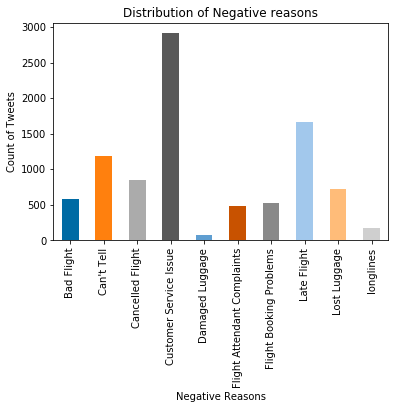

In [117]:
# Lets visualise 
df_mult.groupby(["negative_reason"])["text"].count().plot.bar()
plt.xlabel("Negative Reasons")
plt.ylabel("Count of Tweets")
plt.title("Distribution of Negative reasons")


** it can be seen that customer service related issues are prevalent reason for negative impresssions ** 

In [118]:
list(df_mult.negative_reason.unique())


['Bad Flight',
 "Can't Tell",
 'Late Flight',
 'Customer Service Issue',
 'Flight Booking Problems',
 'Lost Luggage',
 'Flight Attendant Complaints',
 'Cancelled Flight',
 'Damaged Luggage',
 'longlines']

In [119]:
df_mult.head()

,sentiment,negative_reason,text
0,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...
1,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...
2,negative,Can't Tell,@VirginAmerica seriously would pay $30 a fligh...
3,negative,Late Flight,@VirginAmerica SFO-PDX schedule is still MIA.
4,negative,Bad Flight,@VirginAmerica I flew from NYC to SFO last we...


** We will group similar complaints together such as <br> ('longlines', 'Customer Service Issue','Flight Booking Problems', 'Cancelled Flight') as Poor Customer Service, <br> ('Late Flight''Flight Attendant Complaints','Bad Flight') as Poor inflight issues ,<br> ('Lost Luggage','Damaged Luggage') as Lugguage issue , <br>'Can't Tell' as other since I feel that they are closely correlated and could be clubbed toghether **

In [120]:
# Grouping similar negative reasons together
df_mult["negative_reason"]= df_mult["negative_reason"].map({'longlines':'Customer_service','Customer Service Issue':'Customer_service',\
                               'Flight Booking Problems':'Customer_service','Cancelled Flight':'Customer_service',\
                               'Bad Flight':'In_flight_service','Late Flight':'In_flight_service',\
                               'Flight Attendant Complaints':'In_flight_service',\
                               'Lost Luggage':'Lugguage_service','Damaged Luggage':'Lugguage_service','Can\'t Tell':'Other' }
                            )

In [121]:
# Check the distribution of the different kinds of tweets in the new dataframe
df_mult.groupby("negative_reason")["sentiment"].count()

negative_reason
Customer_service     4464
In_flight_service    2726
Lugguage_service      798
Other                1190
Name: sentiment, dtype: int64

In [122]:
df_mult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9178 entries, 0 to 9177
Data columns (total 3 columns):
sentiment          9178 non-null object
negative_reason    9178 non-null object
text               9178 non-null object
dtypes: object(3)
memory usage: 215.2+ KB


In [123]:
# converting the 4 distinct negative reasons to categorical variables
df_mult["negative_reason"]= df_mult["negative_reason"].astype("category")

Text(0.5, 1.0, 'Distribution of Negative reasons')

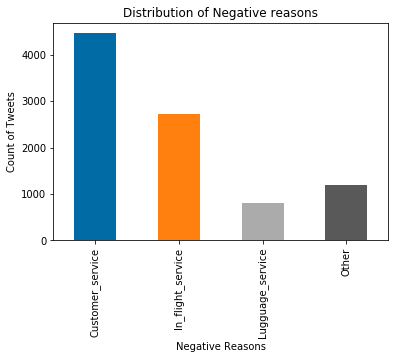

In [124]:
# plotting the negative reasons as bar graph

df_mult.groupby(["negative_reason"])["text"].count().plot.bar()
plt.xlabel("Negative Reasons")
plt.ylabel("Count of Tweets")
plt.title("Distribution of Negative reasons")

In [125]:
# we do not need sentiment column anymore
df_mult.pop("sentiment");

In [126]:
df_mult.head()

,negative_reason,text
0,In_flight_service,@VirginAmerica it's really aggressive to blast...
1,Other,@VirginAmerica and it's a really big bad thing...
2,Other,@VirginAmerica seriously would pay $30 a fligh...
3,In_flight_service,@VirginAmerica SFO-PDX schedule is still MIA.
4,In_flight_service,@VirginAmerica I flew from NYC to SFO last we...


In [127]:
df_mult["negative_reason"].head()

0    In_flight_service
1                Other
2                Other
3    In_flight_service
4    In_flight_service
Name: negative_reason, dtype: category
Categories (4, object): [Customer_service, In_flight_service, Lugguage_service, Other]

In [128]:
df_mult.shape

(9178, 2)

In [129]:
# saving up the order of categories for later use
categories = ['Customer_service', 'In_flight_service', 'Lugguage_service', 'Other']

In [130]:
cvector = CountVectorizer(analyzer='word',min_df=4,ngram_range=(1,3),tokenizer=clean)

In [131]:
bag = cvector.fit_transform(df_mult["text"]) # transforming the tweets using count vectorizer

In [132]:
bag.shape # sanity check 

(9178, 4968)

In [133]:
from sklearn.ensemble import GradientBoostingClassifier

** For Using GB classifier, We need to encode the output as integers **

In [134]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(df_mult["negative_reason"])  # encoding categories as 0,1,2,3

In [135]:
df_mult["negative_reason"][3]

'In_flight_service'

In [136]:
y[3] # looks correct!

1

In [137]:
# Split to train &  test 

In [138]:
X_train_m , X_test_m, y_train_m ,y_test_m = train_test_split(bag, y, test_size = 0.3 , random_state = 99)

In [139]:
# I tried with many classifiers like One VS rest, NB etc , GradientBoostingClassifier gave the best results

In [140]:
model = GradientBoostingClassifier()
model.fit(X_train_m, y_train_m)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [141]:
pred_t = model.predict(X_test_m)

In [142]:
accuracy_score(y_test_m,pred_t)


0.7037037037037037

In [143]:
cm = confusion_matrix(y_test_m, pred_t)
cm

array([[1178,  105,   21,   16],
       [ 249,  542,   21,   13],
       [  47,   10,  179,    3],
       [ 258,   63,   10,   39]])

In [144]:
print(classification_report(y_test_m, pred_t))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77      1320
           1       0.75      0.66      0.70       825
           2       0.77      0.75      0.76       239
           3       0.55      0.11      0.18       370

   micro avg       0.70      0.70      0.70      2754
   macro avg       0.69      0.60      0.60      2754
weighted avg       0.69      0.70      0.67      2754



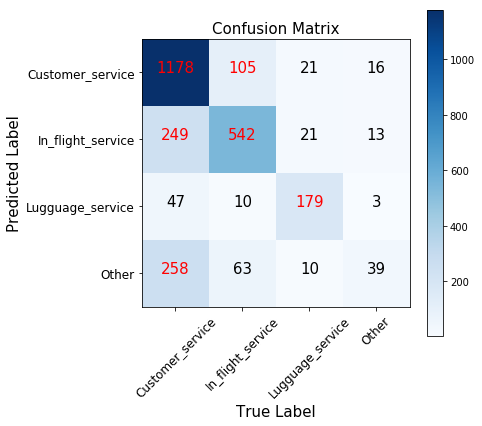

In [145]:
# Plotting Confusion Matrix for better visualization
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, fontsize=12)
plt.yticks(tick_marks, categories, fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 100:
            color = 'red'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Other class has quite a lot  misclassifications 

In [146]:
cvector.inverse_transform(X_test_m[0])# checking the count vectorizer transform

[array(['angri', 'ive', 'laptop', 'phone', 'tri'], dtype='<U24')]

In [147]:
y_test_m[0]

0

## Discussion on wrong classifications

In [148]:
# Predcting the whole data set again so that we easily pick the misclassifications
pred_full = model.predict(bag)

In [149]:
accuracy_score(pred_full,y)

0.733820004358248

In [150]:
print(classification_report(pred_full,y)) # Class 3 ("Other") has very low F1 score

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      5665
           1       0.69      0.77      0.73      2438
           2       0.78      0.79      0.78       792
           3       0.18      0.78      0.30       283

   micro avg       0.73      0.73      0.73      9178
   macro avg       0.64      0.76      0.65      9178
weighted avg       0.81      0.73      0.76      9178



In [151]:
# adding the predictions as a column in data frame for easy viewing 
df_mult["predictions"] = pd.Series(pred_full)
df_mult["predictions"] = df_mult["predictions"].map({0:'Customer_service', 1:'In_flight_service',2: 'Lugguage_service', 3:'Other'})

In [152]:
df_mult.head()

,negative_reason,text,predictions
0,In_flight_service,@VirginAmerica it's really aggressive to blast...,Customer_service
1,Other,@VirginAmerica and it's a really big bad thing...,Customer_service
2,Other,@VirginAmerica seriously would pay $30 a fligh...,In_flight_service
3,In_flight_service,@VirginAmerica SFO-PDX schedule is still MIA.,Customer_service
4,In_flight_service,@VirginAmerica I flew from NYC to SFO last we...,In_flight_service


In [153]:
# finding the false classifications
Fals_classifications = df_mult[pred_full != y]

In [154]:
Fals_classifications.shape

(2443, 3)

In [155]:
Fals_classifications.head()

,negative_reason,text,predictions
0,In_flight_service,@VirginAmerica it's really aggressive to blast...,Customer_service
1,Other,@VirginAmerica and it's a really big bad thing...,Customer_service
2,Other,@VirginAmerica seriously would pay $30 a fligh...,In_flight_service
3,In_flight_service,@VirginAmerica SFO-PDX schedule is still MIA.,Customer_service
9,In_flight_service,@VirginAmerica amazing to me that we can't get...,Customer_service


In [156]:
Fals_classifications.text[2]

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

** Above tweet was classified as "other"(Can't Tell) but I believe the prediction of this tweet as in flight service issue is correct. **


In [157]:
Fals_classifications.tail()

,negative_reason,text,predictions
9139,Other,"@AmericanAir Nah, just horrible dining options...",Customer_service
9151,Customer_service,@AmericanAir @travisamex It's not the weather....,Lugguage_service
9152,In_flight_service,@AmericanAir .....and they waited 5 hours in a...,Lugguage_service
9165,In_flight_service,@AmericanAir 3078 is overweight so you pull 2 ...,Lugguage_service
9169,Other,"@AmericanAir Call me Chairman, or call me Emer...",Customer_service


In [158]:
Fals_classifications.text[9151]

"@AmericanAir @travisamex It's not the weather. It's also gross incompetence. Understaffing. Crew forgetting to load bags. Don't duck truth."

** Above tweet was classified as "other"(/Can't Tell) but this is also very close to a lugguage related tweet. **

In [159]:
Fals_classifications[Fals_classifications["negative_reason"] =="Other"].head()

,negative_reason,text,predictions
1,Other,@VirginAmerica and it's a really big bad thing...,Customer_service
2,Other,@VirginAmerica seriously would pay $30 a fligh...,In_flight_service
24,Other,@VirginAmerica I have no interesting flying wi...,Customer_service
25,Other,@VirginAmerica it was a disappointing experien...,Customer_service
27,Other,@VirginAmerica Why is the site down? When wil...,Customer_service


In [160]:
Fals_classifications.text[27]

'@VirginAmerica Why is the site down?  When will it be back up?'

 Above tweet was classified as "other"(Can't Tell) but this is also very close to a Customer Serivce issue 

** Most of the missclassifications happpened where "Other" was missclassfied to "Customer Service" . Looking at the tweets I see that some of the "Other" Labeled tweets resemble "Customer Service" Tweets and the vocabulary is very similar.This makes the classifier to easily misclassify them . <br>
Another issue is with the inherent draw back of  bag of words model where not even the 3 gram model captures the subject of the given tweet. This is crucial in defining the direction of the tweet of any text analyisis .**

** For the first model , I found some tweets in different language like spanish & there were many spelling mistakes that were not corrected/recogized by cleaner or bag of words . There were some encoding issue that I could not figure out so the model just removed them.<br>  if I can fix these , I believe the model will perform better**

** While fitting the generic model to Airline tweets, I believe the generic vocabulary did not capture all the airline specific words since the training set was generic. This I believe is one reason for the low accuracy . Also since the dataset itself is skewed we should try to balance the data by running algorithms like SMOTE . **

** One of the remedy that I can think we can do to improve accuracy is to use LSTM based neural networks which can keep some attributes such as subject of the sentence in memory , some bidirectional models can even get feedback from the end a sentence.  **

# Thank you 